# OpenBikeSensor Workshop

## Datenanalyse mit ein bischen Code :)



## Unterwegs mit dem OpenBikeSensor
![OpenBikeSensor](img/obs.gif)

In [2]:
# Importieren der Hilfsprogramme
import keplergl   #  Karten anzeigen
import geopandas  # Daten analysieren
import pygeos # Daten analysieren
import json # JSON dateien lesen und bearbeiten können
import numpy as np
import matplotlib.pyplot as plt


In [3]:
# Zentrale Funktion zum Laden von Daten
def lade_daten(dateiname) -> geopandas.GeoDataFrame:
    with open(dateiname, "r") as f:
        geojson = json.load(f)
    
    spalten = ["geometry"]

    #add all properties to gdf cols
    for property_key in geojson["features"][0]["properties"].keys():
        spalten.append(property_key)

    gdf = geopandas.GeoDataFrame.from_features(geojson["features"], crs="EPSG:4326", columns=spalten)
    # gdf = gdf.to_crs("EPSG:25832")  # reproject to utm coords

    return gdf



In [4]:
# Laden der OpenBikeSensor Messungen
obs_messdaten = lade_daten("wilhelmsburg_data/obs_messdaten_wilhelmsburg.json")

# Anzeigen der Daten auf einer Karte
karte_1=keplergl.KeplerGl(height=400)
karte_1.add_data(data=obs_messdaten, name="OBS Messdaten")  # todo config einfügen.
karte_1 # Karte starten

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'OBS Messdaten': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 1…

## Verkehrsflächen laden
### Wir laden die Kartendaten für Fahrbahnen, Parkplätze, Radwege und Gehwege
 
![Uebersicht alle Verkehrsflächen](img/verkehrsflaechen.png) 

In [5]:

# Fahrbahnen Autos laden
fahrbahn = lade_daten("wilhelmsburg_data/Fahrbahn.json")

# Datensatz mit Parkplätzen für ganz Hamburg laden
# TODO vogelhüttendeich mit rein
parkplatz = lade_daten("wilhelmsburg_data/Parkplatz.json")

# Radwege laden
radwege = lade_daten("wilhelmsburg_data/Radweg.json")

# Gehwege laden
gehwege = lade_daten("wilhelmsburg_data/Gehweg.json")





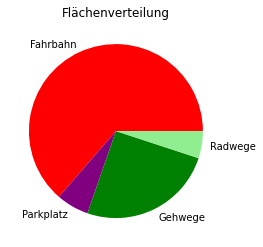

In [6]:
# Frage: Wie sind die Flächen für Gehwege, Fahrräder und Autos verteilt? 
def flaeche_in_qm_berechnen(datensatz):
    datensatz_metrisch = datensatz.to_crs("EPSG:25832")  # als metrische Koordinaten speichern
      
    return datensatz_metrisch.area.sum()


fahrbahn_flaeche = flaeche_in_qm_berechnen(fahrbahn)
parkplatz_flaeche = flaeche_in_qm_berechnen(parkplatz)
radwege_flaeche = flaeche_in_qm_berechnen(radwege)
gehwege_flaeche = flaeche_in_qm_berechnen(gehwege)
gesamt_flaeche = fahrbahn_flaeche + parkplatz_flaeche + radwege_flaeche + gehwege_flaeche

fahrbahn_prozent =  round((fahrbahn_flaeche / gesamt_flaeche) * 100)
parkplatz_prozent = round((parkplatz_flaeche / gesamt_flaeche) * 100)
gehwege_prozent = round((gehwege_flaeche / gesamt_flaeche) * 100)
radwege_prozent = round((radwege_flaeche / gesamt_flaeche) * 100)

# create dataset
bars = ('Fahrbahn', 'Parkplatz', 'Gehwege', 'Radwege')
werte = [fahrbahn_prozent, parkplatz_prozent, gehwege_prozent, radwege_prozent]
 
# Create bars and choose color
plt.pie(werte, labels=bars, colors=['red', 'purple', 'green', 'lightgreen'])
 
# Add title and axis names
plt.title('Flächenverteilung')
 
# Show graph
plt.show()



## In der Praxis sieht das dann so aus
![Parkplatzsuche](img/cars2.gif)


## Was würde sich ändern, wenn die Flächenverteilung umgekehrt aussehe?
![bikes](img/bikes.gif)

So viele Überholungen waren zu eng 74
So viele Überholungen gab es insgesamt 95
So viele Überholungen waren nicht zu eng 21
Der Überholabstand im Durchschnitt 1.16 meter


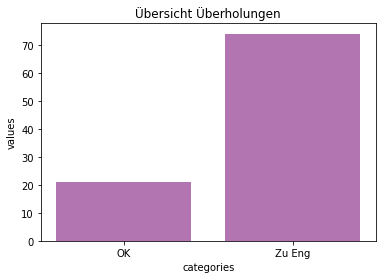

In [8]:
anzahl_alle_ueberholungen = obs_messdaten["abstand_links"].count()

# Filtern aller Messdaten mit Überholabständen unter 1.5 Meter
zu_enge_ueberholungen = obs_messdaten[obs_messdaten["abstand_links"] < 1.5]
anzahl_zu_enge_ueberholungen = zu_enge_ueberholungen["abstand_links"].count()

anzahl_OK_ueberholungen = anzahl_alle_ueberholungen - anzahl_zu_enge_ueberholungen


# Wie viele sind das eigentlich? 
print("So viele Überholungen waren zu eng", anzahl_zu_enge_ueberholungen)
print("So viele Überholungen gab es insgesamt", anzahl_alle_ueberholungen)
print("So viele Überholungen waren nicht zu eng", anzahl_OK_ueberholungen)

print(f'Der Überholabstand im Durchschnitt {round(obs_messdaten["abstand_links"].mean(), 2)} meter' )

# create dataset
bars = ('OK', 'Zu Eng')
x_pos = np.arange(len(bars))
 
# Create bars and choose color
plt.bar(x_pos, [anzahl_OK_ueberholungen, anzahl_zu_enge_ueberholungen], color = (0.5,0.1,0.5,0.6))
 
# Add title and axis names
plt.title('Übersicht Überholungen')
plt.xlabel('categories')
plt.ylabel('values')
 
# Create names on the x axis
plt.xticks(x_pos, bars)
 
# Show graph
plt.show()

In [9]:
# Frage: Bei wie viel % der zu engen überholungen war auch rechts kein platz?
auch_rechts_kein_platz = zu_enge_ueberholungen[zu_enge_ueberholungen["abstand_rechts"] < 1.5]
anzahl_auch_rechts_kein_platz = auch_rechts_kein_platz["abstand_rechts"].count()
prozent = round((anzahl_auch_rechts_kein_platz / anzahl_zu_enge_ueberholungen) * 100)
print(f"Bei {prozent} % Überholungen war auch rechts kein Platz")





Bei 57 % Überholungen war auch rechts kein Platz


![Dooring](img/dooring.jpg)



## Frage : Wird enger überholt, wenn es Parkplätze an der Seite gibt? 

### Ansatz zur Berechnung: 
    1) Wir blasen die Messpunkte zu Kreisen mit 3meter Durchmesser auf
    2) Wir schauen wie viele dieser Messpunkte sich mit Parkplätzen überschneiden
    
![Messpunkte und Parklätze](img/buffer.png)


In [10]:
parkplatz = parkplatz.to_crs("EPSG:25832")    #  Parkplätze zuerst in metrische Koordinaten umwandeln


# 1) Aufblasen der Messpunkte zu Kreisen mit Durchmesser von 2metern
messdaten = lade_daten("wilhelmsburg_data/obs_messdaten_wilhelmsburg.json").to_crs("EPSG:25832") # zuerst in metrische Koordinaten umwandeln
messpunkte = messdaten.copy()
messpunkte['geometry'] = messpunkte.geometry.buffer(3)


# 2) Filtern der Messpunkte, die innerhalb der vergrößerten Parkplatzflächen liegen

# Dazu Datensets von Messdaten und Parkplätzen kombinieren
messdaten_und_parkplaetze = messpunkte.sjoin(parkplatz, how="left")
ueberholungen_bei_parkplaetzen = messdaten_und_parkplaetze[messdaten_und_parkplaetze["nutzung"] == "Parkplatz"]
ueberholungen_bei_parkplaetzen = ueberholungen_bei_parkplaetzen.drop_duplicates(["time"])


# 3) Auswertung
# Wie oft wurde in der Nähe von Parkplätzen zu eng überholt?
zu_enge_ueberholungen_bei_parkplaetzen = ueberholungen_bei_parkplaetzen[ueberholungen_bei_parkplaetzen["abstand_links"] < 1.5]

# Wenn ein Parkplatz in der Nähe ist - Ist dann die Wahrscheinlichkeit größer, das eng überholt wird?
anzahl_ueberholungen_bei_parkplaetzen = ueberholungen_bei_parkplaetzen["abstand_links"].count()
anzahl_zu_enge_ueberholungen_bei_parkplaetzen = zu_enge_ueberholungen_bei_parkplaetzen["abstand_links"].count()
prozent = round((anzahl_zu_enge_ueberholungen_bei_parkplaetzen / anzahl_ueberholungen_bei_parkplaetzen) * 100)
print(f"{prozent} % der Überholungen neben Parkplätzen waren zu eng.")


# Aber ist ein Parkplatz in der Nähe ein Voraussetzung dafür, dass zu eng überholt wird?
print("Zu enge Überholungen insgesamt" , anzahl_zu_enge_ueberholungen)
print("Bei Parkplätzen", anzahl_zu_enge_ueberholungen_bei_parkplaetzen)
# Es wird also auch eng überholt, wenn keine Parkplätze in der Nähe sind 



FileNotFoundError: [Errno 2] No such file or directory: 'obs_messdaten_wilhelmsburg.json'

## Überholt werden neben einem parkenden Auto
### Wie fühlt ihr Euch dabei?
![cars](img/cars.gif)

In [1]:
# Bei wie vielen zu engen Überholungen war kein Fahrradweg in der Nähe?

# Aufblasen der Messpunkte zu Kreisen mit Durchmesser von 2metern
messdaten = lade_daten("obs_messdaten_wilhelmsburg.json").to_crs("EPSG:25832") # zuerst in metrische Koordinaten umwandeln
messpunkte = messdaten.copy()
messpunkte['geometry'] = messpunkte.geometry.buffer(15)

# Filtern der Messpunkte, die innerhalb der vergrößerten Parkplatzflächen liegen
radwege = radwege.to_crs("EPSG:25832")    # zuerst in metrische Koordinaten umwandeln

# Datensets von Messdaten und Parkplätzen kombinieren
messpunnkte_und_radwege = messpunkte.sjoin(radwege, how="left")
ueberholungen_bei_radwegen = messpunnkte_und_radwege[messpunnkte_und_radwege["nutzung"] == "Radweg"]
ueberholungen_bei_radwegen = ueberholungen_bei_radwegen.drop_duplicates(["time"])


# Wie oft wurde in der Nähe von Radwegen zu eng überholt?
zu_enge_ueberholungen_bei_radwegen = ueberholungen_bei_radwegen[ueberholungen_bei_radwegen["abstand_links"] < 1.5]

# Wenn ein Radweg in der Nähe ist - Ist dann die Wahrscheinlichkeit kleiner, das eng überholt wird?
anzahl_alle_ueberholungen_bei_radwegen = ueberholungen_bei_radwegen["abstand_links"].count()
anzahl_zu_enge_ueberholungen_bei_radwegen = zu_enge_ueberholungen_bei_radwegen["abstand_links"].count()
prozent = round((anzahl_zu_enge_ueberholungen_bei_radwegen / anzahl_alle_ueberholungen_bei_radwegen) * 100)
print(prozent)


# Aber ist ein Parkplatz in der Nähe ein Voraussetzung dafür, dass zu eng überholt wird?
print("Zu enge Überholungen insgesamt" , anzahl_zu_enge_ueberholungen)
print("Bei Radwegen", anzahl_zu_enge_ueberholungen_bei_radwegen)


NameError: name 'lade_daten' is not defined